# Wine and Dine the Dataset: Polyp Segmentation Dataset

[source](https://www.kaggle.com/datasets/shuvoalok/cvc-clinicdb)

Inventory, validate, and explore dataset files.  Shoot, this is a SMALL dataset... it'll need augmentation.

In [2]:
import sys

sys.path.append('../src')

import snek_utils as snu

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import tifffile as tif

from typing import List

pd.set_option('display.max_columns', None)

%matplotlib inline

## Basic File Listing

In [3]:
# Specify the directory path you want to start from
directory_path = Path('D:/Downloads/Datasets/archive')
paths = snu.list_files_pathlib(directory_path)

len(paths), paths[:5]

(1225,
 ['D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/1.tif',
  'D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/10.tif',
  'D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/100.tif',
  'D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/101.tif',
  'D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/102.tif'])

In [4]:
all_files = pd.DataFrame()

all_files['filepaths'] = paths
all_files['filename'] = [Path(x).name for x in paths]
all_files['filetype'] = [Path(x).suffix.replace('.','').lower() for x in paths]
all_files['directory'] = [x.split('/')[-2] for x in paths]

all_files.info()
all_files.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  1225 non-null   object
 1   filename   1225 non-null   object
 2   filetype   1225 non-null   object
 3   directory  1225 non-null   object
dtypes: object(4)
memory usage: 38.4+ KB


,filepaths,filename,filetype,directory
0,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,1.tif,tif,Ground Truth
1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,10.tif,tif,Ground Truth
2,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,100.tif,tif,Ground Truth
3,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,101.tif,tif,Ground Truth
4,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...,102.tif,tif,Ground Truth


In [5]:
print(all_files['directory'].value_counts(), '\n')

print(all_files['filetype'].value_counts())

directory
Ground Truth    612
Original        612
CVC-ClinicDB      1
Name: count, dtype: int64 

filetype
tif    1224
txt       1
Name: count, dtype: int64


## Check out the README

In [6]:
all_files[all_files['filetype'] == 'txt']

,filepaths,filename,filetype,directory
1224,D:/Downloads/Datasets/archive/CVC-ClinicDB/REA...,README.txt,txt,CVC-ClinicDB


In [7]:
readme = all_files.at[1224, 'filepaths']

print(readme, '\n')

with open(readme, 'r') as file:
    # Read the content of the file
    file_content = file.read()
    
    # Print the content
    print('File Content:\n', file_content)

D:/Downloads/Datasets/archive/CVC-ClinicDB/README.txt 

File Content:
 CVC-ClinicDB

--------------------------------------------------
Introduction
--------------------------------------------------

CVC-ClinicDB is a database of frames extracted from colonoscopy videos. 
These frames contain several examples of polyps. In addition to the frames, we provide the ground truth for the polyps. 
This ground truth consists of a mask corresponding to the region covered by the polyp in the image.

CVC-ClinicDB has been generated from 25 different video studies. For each study at least a sequence containing a polyp was extracted. Considering this, CVC-ClinicDB database is composed by frames from 29 different sequences containing a polyp. 

Finally, a set of frames were selected from each sequence, paying particular attention in showing several points of view of the polyp. 

--------------------------------------------------
Description
--------------------------------------------------

The da

## Detailed file labeling

In [8]:
#  Dataset page groups sets of endoscopy frames by sequence. These are described in a table,
# but since we'll want to use them for stratified sampling, I made a csv to keep track.

labels = pd.read_csv('../data/CVC-ClinicDB-sequence-labels.csv')
labels.info()
labels.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   frame_number  612 non-null    int64
 1   sequence      612 non-null    int64
dtypes: int64(2)
memory usage: 9.7 KB


,frame_number,sequence
0,1,1
1,2,1
2,3,1


In [12]:
# Validate filename matching

df = all_files[all_files['filetype'] == 'tif']

# Sort ground truth lables into separate dataframe
gt = df[df['directory'] == 'Ground Truth']
gt = gt.sort_values(by='filename').reset_index(drop=True)

# We're going to merge these back together, so rename
gt = gt.rename(columns={'filepaths':'gt_filepath'})

# Capture frame number so we can merge with sequence label
gt['frame_number'] = [Path(x).stem for x in gt['gt_filepath']]

# Do the same stuff with the photos
imgs = df[df['directory'] != 'Ground Truth'].reset_index(drop=True)
imgs = imgs.sort_values(by='filename').reset_index(drop=True)

imgs = imgs.rename(columns={'filepaths':'img_filepath'})
imgs['frame_number'] = [Path(x).stem for x in imgs['img_filepath']]

# Since we sorted them and the filenames should 
# be the same, this statement should pass
assert list(gt['filename']) == list(imgs['filename'])

gt.info()
imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gt_filepath   612 non-null    object
 1   filename      612 non-null    object
 2   filetype      612 non-null    object
 3   directory     612 non-null    object
 4   frame_number  612 non-null    object
dtypes: object(5)
memory usage: 24.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img_filepath  612 non-null    object
 1   filename      612 non-null    object
 2   filetype      612 non-null    object
 3   directory     612 non-null    object
 4   frame_number  612 non-null    object
dtypes: object(5)
memory usage: 24.0+ KB


In [21]:
# Merge them back together into a single dataframe and merge with sequence labels

gt = gt[['frame_number','filename','filetype','gt_filepath']]
imgs = imgs[['frame_number','filename','filetype','img_filepath']]

dat = gt.merge(imgs, on=['frame_number','filename','filetype'])

# Have to convert to int since we grabbed from path string
dat['frame_number'] = dat['frame_number'].astype(int)
dat = dat.merge(labels, on='frame_number')

# Sorting columns to personal taste
dat = dat[['filename','frame_number','sequence','img_filepath','gt_filepath']]

dat = dat.sort_values(by=['frame_number']).reset_index(drop=True)

dat.info()
dat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      612 non-null    object
 1   frame_number  612 non-null    int32 
 2   sequence      612 non-null    int64 
 3   img_filepath  612 non-null    object
 4   gt_filepath   612 non-null    object
dtypes: int32(1), int64(1), object(3)
memory usage: 21.6+ KB


,filename,frame_number,sequence,img_filepath,gt_filepath
0,1.tif,1,1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Ori...,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...
1,2.tif,2,1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Ori...,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...
2,3.tif,3,1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Ori...,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...
3,4.tif,4,1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Ori...,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...
4,5.tif,5,1,D:/Downloads/Datasets/archive/CVC-ClinicDB/Ori...,D:/Downloads/Datasets/archive/CVC-ClinicDB/Gro...


In [22]:
dat.to_csv('../data/CVC-ClinicDB-dataset.csv')

## Sequence distribution

In [23]:
len(dat['sequence'].unique())

29

In [34]:
seq = dat['sequence'].value_counts()
seq = seq.sort_values()
seq

sequence
10     6
4     11
23    12
3     17
26    18
22    19
21    19
15    20
28    20
20    20
14    20
18    20
29    21
17    21
11    22
9     22
6     23
16    25
2     25
19    25
13    25
12    25
24    25
7     25
5     25
25    25
27    25
1     25
8     26
Name: count, dtype: int64

In [32]:
seq = seq.sort_index()
seq

sequence
1     25
2     25
3     17
4     11
5     25
6     23
7     25
8     26
9     22
10     6
11    22
12    25
13    25
14    20
15    20
16    25
17    21
18    20
19    25
20    20
21    19
22    19
23    12
24    25
25    25
26    18
27    25
28    20
29    21
Name: count, dtype: int64

So 29 sequences with n frames ranging from 6 all the way up to 26.

## Let's look

D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/1.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/1.tif


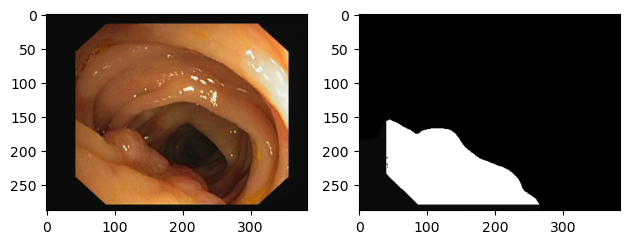

In [35]:
i = 0

gt_pth = dat.at[i, 'gt_filepath']
gt_im = tif.imread(gt_pth)

im_pth = dat.at[i, 'img_filepath']
im = tif.imread(im_pth)

print(gt_pth)
print(im_pth)

plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(gt_im, cmap='gray')

plt.tight_layout()
plt.show()

SEQUENCE: 1
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/2.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/2.tif


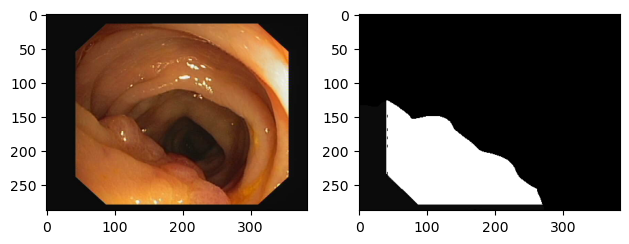

SEQUENCE: 2
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/30.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/30.tif


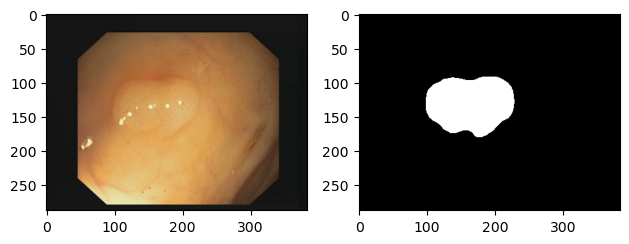

SEQUENCE: 3
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/54.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/54.tif


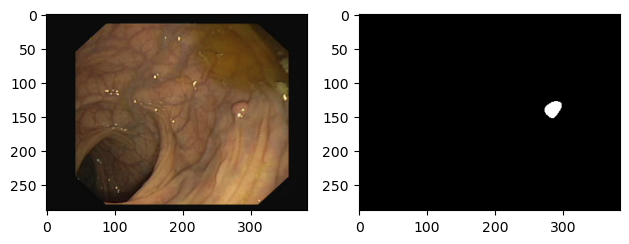

SEQUENCE: 4
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/70.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/70.tif


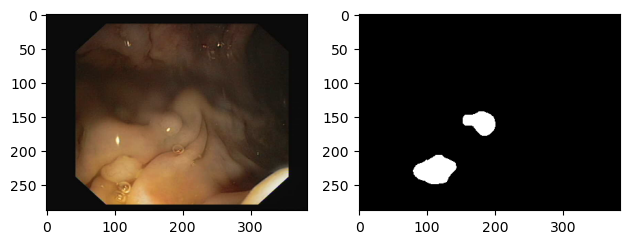

SEQUENCE: 5
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/81.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/81.tif


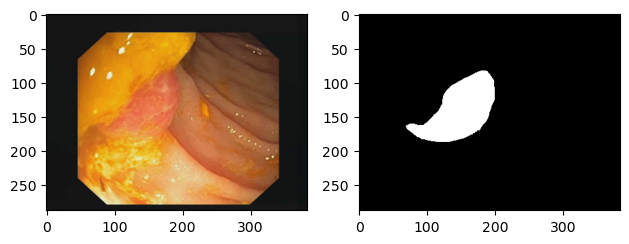

SEQUENCE: 6
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/126.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/126.tif


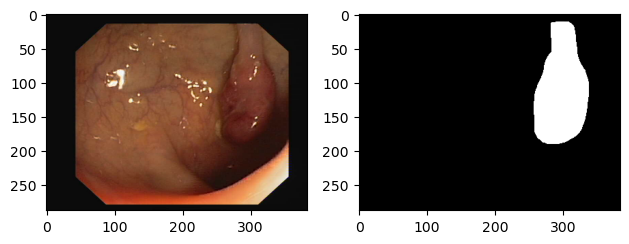

SEQUENCE: 7
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/132.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/132.tif


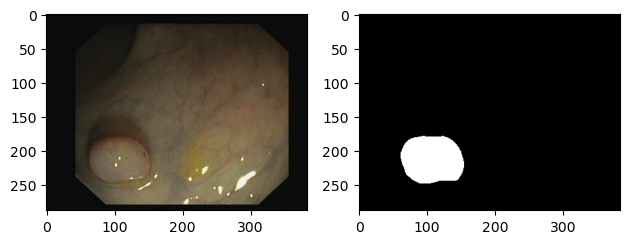

SEQUENCE: 8
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/165.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/165.tif


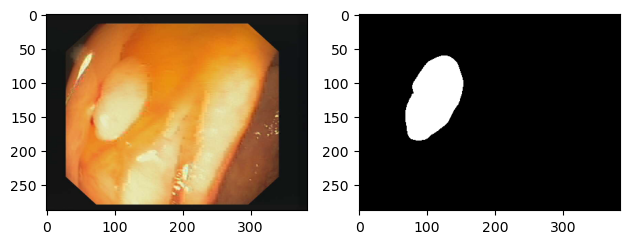

SEQUENCE: 9
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/183.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/183.tif


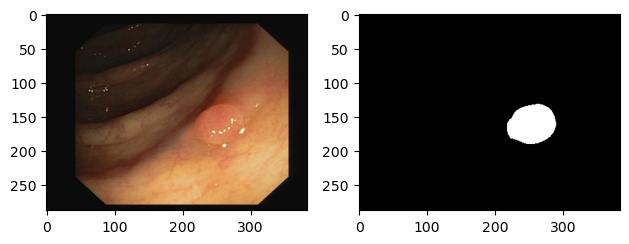

SEQUENCE: 10
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/201.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/201.tif


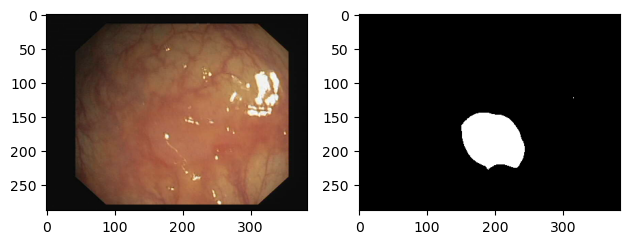

SEQUENCE: 11
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/220.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/220.tif


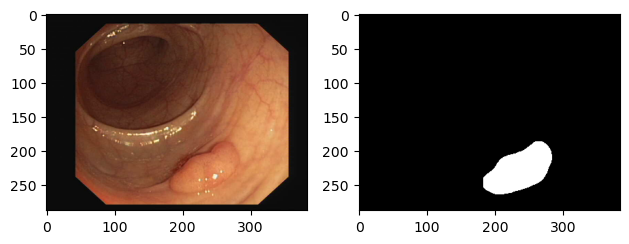

SEQUENCE: 12
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/232.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/232.tif


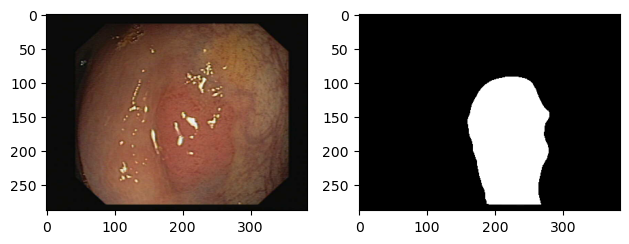

SEQUENCE: 13
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/276.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/276.tif


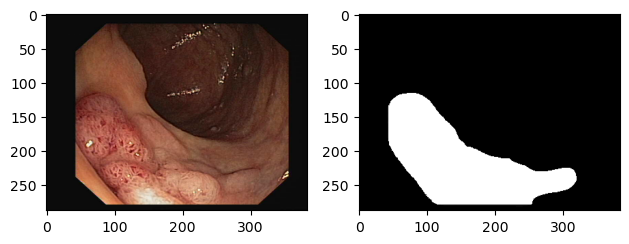

SEQUENCE: 14
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/289.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/289.tif


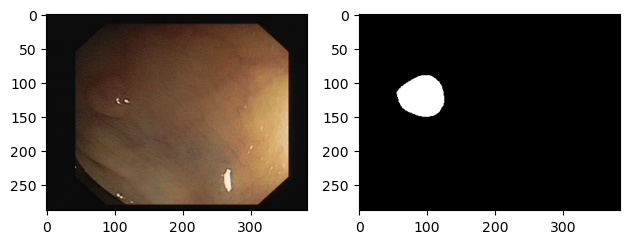

SEQUENCE: 15
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/299.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/299.tif


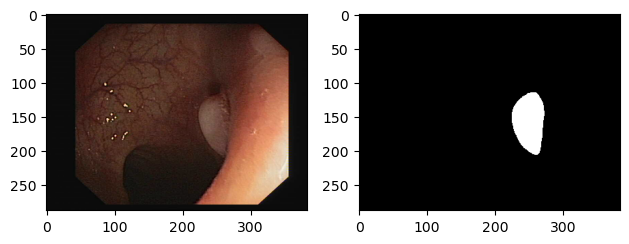

SEQUENCE: 16
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/319.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/319.tif


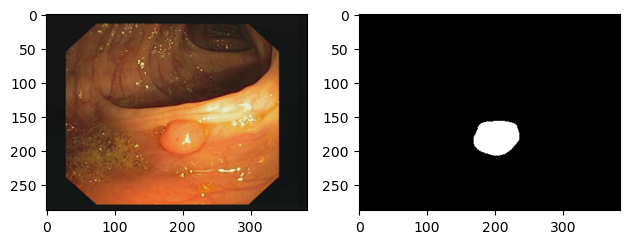

SEQUENCE: 17
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/346.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/346.tif


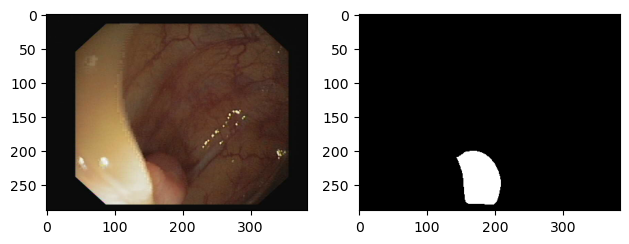

SEQUENCE: 18
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/371.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/371.tif


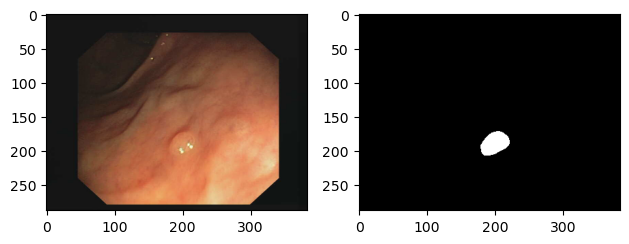

SEQUENCE: 19
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/390.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/390.tif


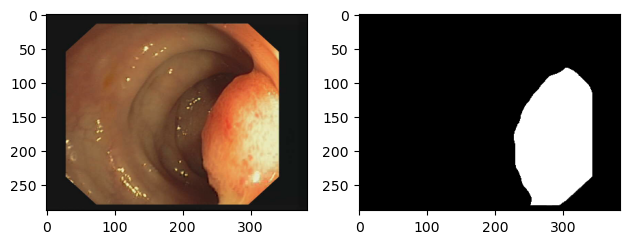

SEQUENCE: 20
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/426.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/426.tif


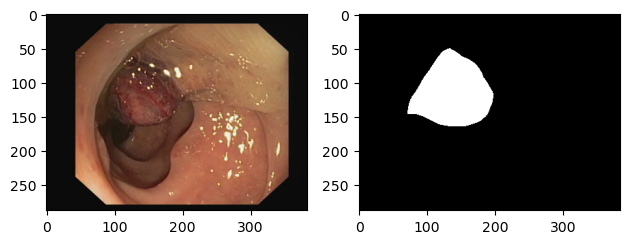

SEQUENCE: 21
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/439.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/439.tif


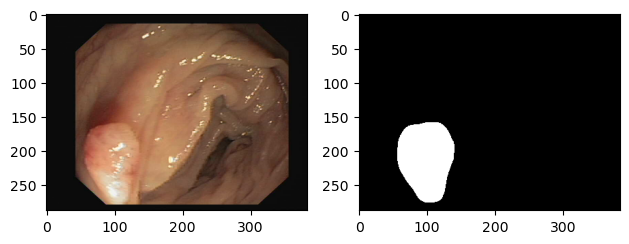

SEQUENCE: 22
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/464.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/464.tif


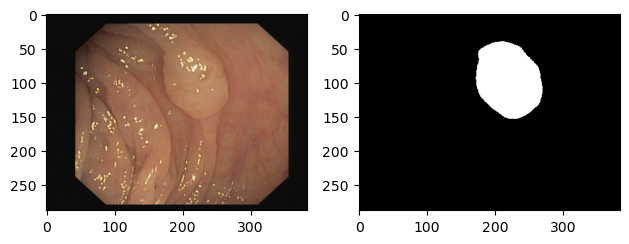

SEQUENCE: 23
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/467.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/467.tif


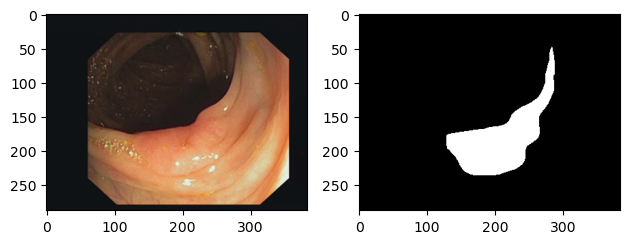

SEQUENCE: 24
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/480.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/480.tif


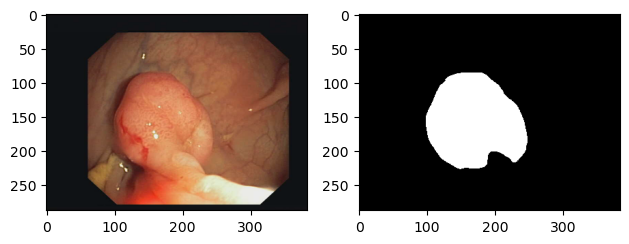

SEQUENCE: 25
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/510.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/510.tif


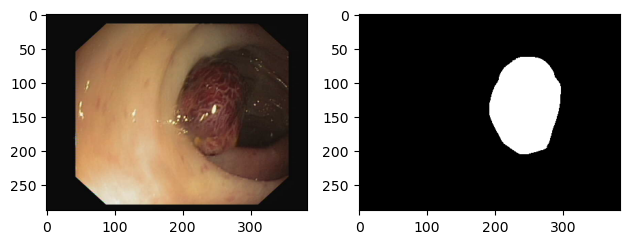

SEQUENCE: 26
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/540.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/540.tif


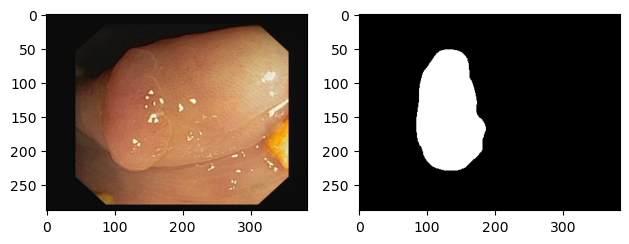

SEQUENCE: 27
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/553.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/553.tif


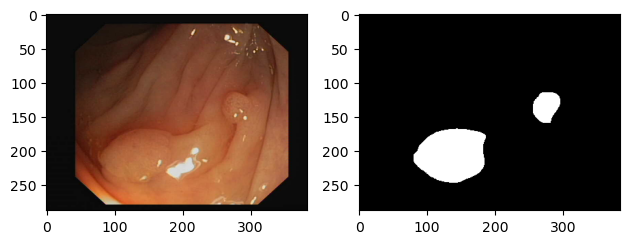

SEQUENCE: 28
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/575.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/575.tif


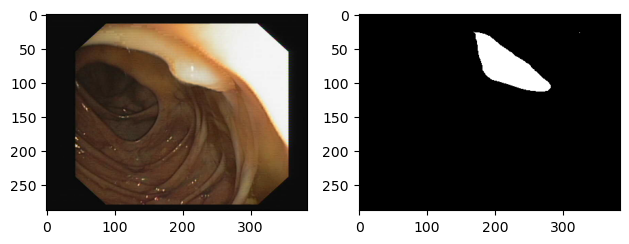

SEQUENCE: 29
D:/Downloads/Datasets/archive/CVC-ClinicDB/Original/593.tif
D:/Downloads/Datasets/archive/CVC-ClinicDB/Ground Truth/593.tif


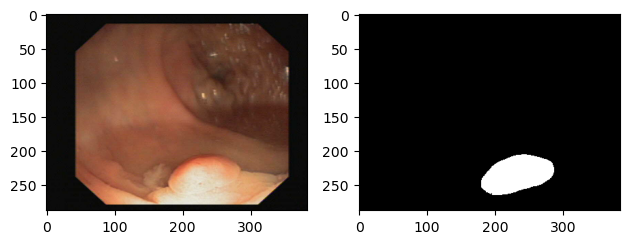

In [37]:
# Let's get a sample of each sequence

sequences = list(set(dat['sequence']))
sequences.sort()

i = 0

for seq in sequences:
    tmp = dat[dat['sequence'] == seq]
    tmp = tmp.sample(1).reset_index(drop=True)

    gt_pth = tmp.at[i, 'gt_filepath']
    gt_im = tif.imread(gt_pth)
    
    im_pth = tmp.at[i, 'img_filepath']
    im = tif.imread(im_pth)
    
    print(f'SEQUENCE: {seq}\n{im_pth}\n{gt_pth}')
    
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.subplot(1,2,2)
    plt.imshow(gt_im, cmap='gray')
    plt.tight_layout()
    plt.show()